---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>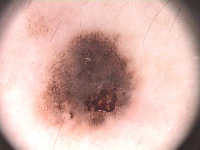</td><td>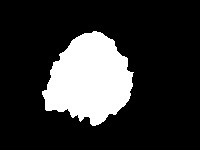</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2023-11-11 10:53:10--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-11-11 10:53:10--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc445d5e607c5f889d359fa6bec2.dl.dropboxusercontent.com/cd/0/inline/CHVmuPp4Xzb0hVSPXnBhaKlBBgS8BRwNGK_WpMHwA24xnPoPif1t8KBur0VxBpBNDmA4O7e5Aqh7nVXctETTUkt2zHj3zJWzzXfjIr3Ugt_PhjI2ntndtuKTGfAn5HVftG4/file# [following]
--2023-11-11 10:53:11--  https://uc445d5e607c5f889d359fa6bec2.dl.dropboxusercontent.com/cd/0/inline/CHVmuPp4Xzb0hVSPXnBhaKlBBgS8BRwNGK_WpMHwA24xnPoPif1t8KBur0VxBpBNDmA4O7e5Aqh7nVXctETTUkt2zHj3zJWzzXfjIr3Ugt_PhjI2ntndt

In [ ]:
!ls

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [2]:
os.path.join(root, 'PH2 Dataset images')

'PH2Dataset\\PH2_Dataset\\IMD437\\IMD437_lesion\\PH2 Dataset images'

In [3]:
import matplotlib.pyplot as plt

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

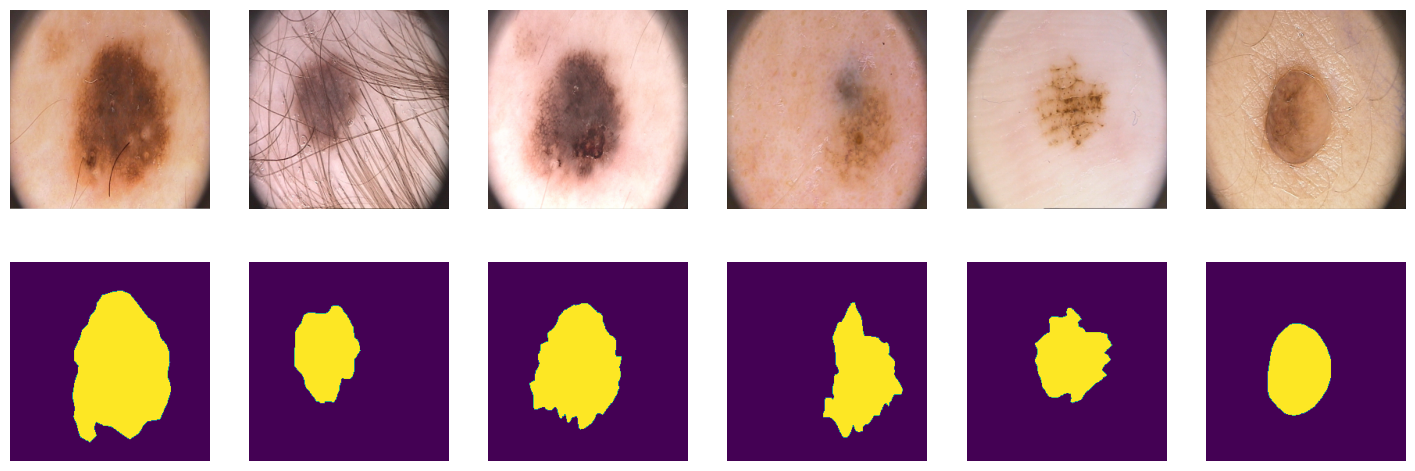

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [12]:
a=torch.tensor([1,2,3]).to(device)
a

tensor([1, 2, 3], device='cuda:0')

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

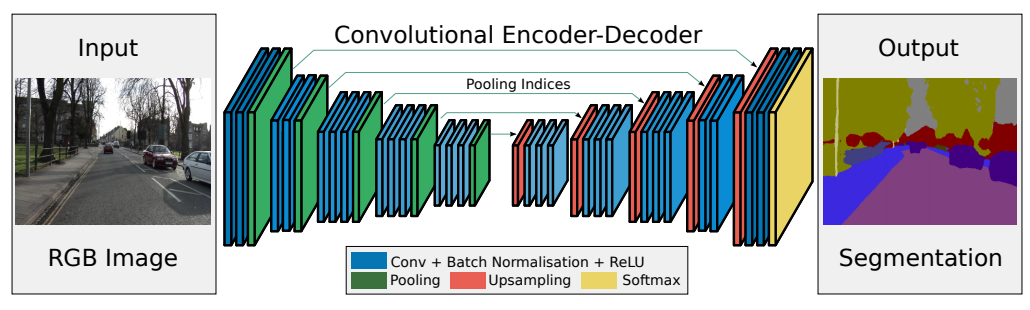

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
# Поскольку сеть из многих повторяющихся блоков, сделаем такой блок классом

class OneUnit(nn.Module):
    """
    Блок Conv2D + BatchNorm + Relu
    param ker_size: размер стороны квадратного ядра свёртки, int
    param stride_size: отступ страйда, int
    param pad_size: отступ паддинга, int
    """
    def __init__(self, in_channels, out_channels, ker_size, stride_size, pad_size):
        super(OneUnit, self).__init__()
        self.unit = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=ker_size, 
                      padding=pad_size, stride=stride_size),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.unit(x)

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            OneUnit(3,  64, 3, 1, 1),
            OneUnit(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            OneUnit(64,  128, 3, 1, 1),
            OneUnit(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            OneUnit(128, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            OneUnit(256, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottle_neck = nn.Sequential(
            OneUnit(512, 512, 1, 1, 0),
            OneUnit(512, 512, 1, 1, 0),
            OneUnit(512, 512, 1, 1, 0),
            OneUnit(512, 512, 1, 1, 0)   
        )

        # decoder (upsampling)

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            OneUnit(128, 128, 3, 1, 1),
            OneUnit(128,  64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            OneUnit(64, 64, 3, 1, 1),

            # последний блок отличается от паттерна
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # в последнем слое активация не нужна
        )

    def forward(self, inp):
        # encoder
        enc0, idx0 = self.pool0(self.enc_conv0(inp))
        enc1, idx1 = self.pool1(self.enc_conv1(enc0))
        enc2, idx2 = self.pool2(self.enc_conv2(enc1))
        enc3, idx3 = self.pool3(self.enc_conv3(enc2))        

        # bottleneck        
        neck = self.bottle_neck(enc3)

        # decoder
        dec3 = self.dec_conv3(self.upsample3(neck, idx3))
        dec2 = self.dec_conv2(self.upsample2(dec3, idx2))
        dec1 = self.dec_conv1(self.upsample1(dec2, idx1))
        dec0 = self.dec_conv0(self.upsample0(dec1, idx0))

        # no activation
        return dec0

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [15]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, treshold=0.5, SMOOTH=1e-8):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()             # BATCH x 1 x H x W => BATCH x H x W
    labels  = labels.squeeze(1).byte()
    
    inter = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both are 0
    
    iou = (inter + SMOOTH) / (union + SMOOTH)                       # We avoid 0/0
    # [0, 1] => [-1, 1]
    return torch.clamp(20 * (iou - treshold), 0, 10).ceil() / 10

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [16]:
def bce_loss(y_pred, y_real):
    loss = (1 - y_real) * y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [17]:
from IPython.display import clear_output
import gc

def train(model, opt, loss_fn, epochs, data_tr, data_val, metric=iou_pytorch):
    if is_cuda:
        torch.cuda.empty_cache()
    gc.collect()
    losses = {'train': [], 'valid': []}
    scores = []
    for epoch in range(1, epochs+1):
        tic = time()
        print(f'* Epoch:\t{epoch}/{epochs}')
        avg_loss = 0
        model.train()  # train mode

        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)    

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss   = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()                   # backward-pass
            opt.step()                        # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(f'train_loss:\t{avg_loss}')
        losses['train'].append(avg_loss.item())

        # show intermediate results
        model.eval() 
        avg_loss = 0
        for X_val, Y_val in data_val:   # testing mode
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).detach().cpu()   # detach and put into cpu
                loss = loss_fn(Y_hat, Y_val)                     # forward-pass
                avg_loss += loss / len(data_val)
        losses['valid'].append(avg_loss.item())
        
        scores.append(score_model(model, metric, data_val))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'{epoch} / {epochs} - val_loss: {avg_loss:.5f}, val_metr: {scores[-1]:.5f}')
        plt.show()
        
    return [losses, scores]

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [18]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [19]:
def score_model(model, metric, data, treshold=0.5):
    model.eval()               # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = torch.sigmoid(model(X_batch.to(device)))
            Y_pred = torch.where(Y_pred > treshold, 1, 0)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores / len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [20]:
model = SegNet().to(device)

In [29]:
torch.cuda.empty_cache()
gc.collect()

0

In [20]:
!nvidia-smi

Mon Nov 27 21:09:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P2              53W / 200W |    859MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

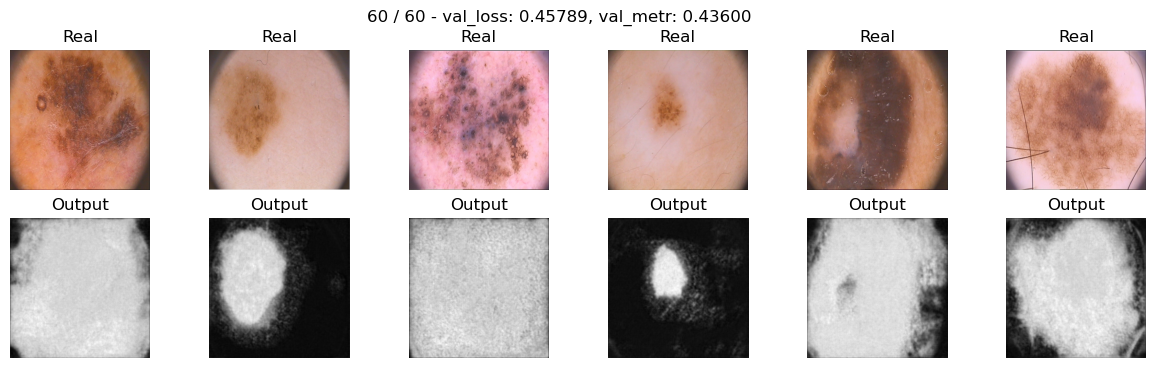

In [25]:
max_epochs = 60
optim=torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
res_dice, acc_dice = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [26]:
score_model(model, iou_pytorch, data_val)

0.4359999895095825

Ответьте себе на вопрос: не переобучается ли моя модель?

Для 60 эпох на 20-59й эпохе score был примерно равен 0.62-0.66. а на **_ровно_** 60й эпохе он стал 0.436, что свидетельствует о переобучении, так что сейчас обучу на 50 эпохах


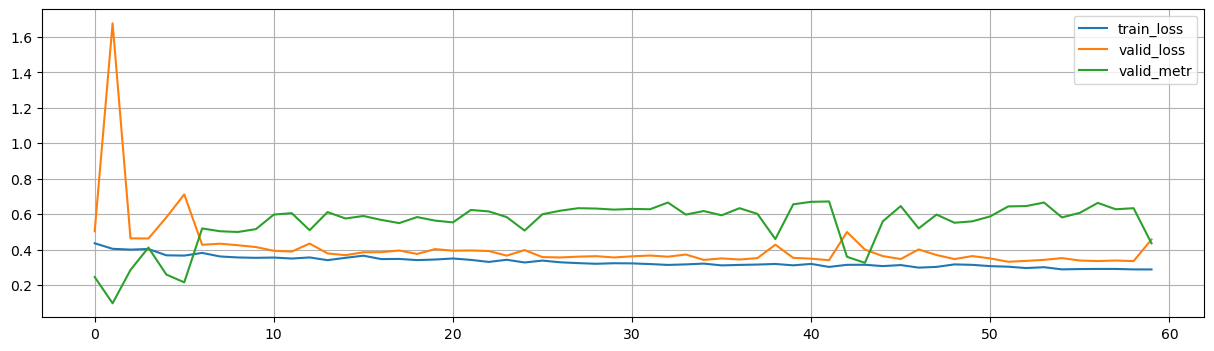

In [28]:
res, acc = res_dice, acc_dice
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

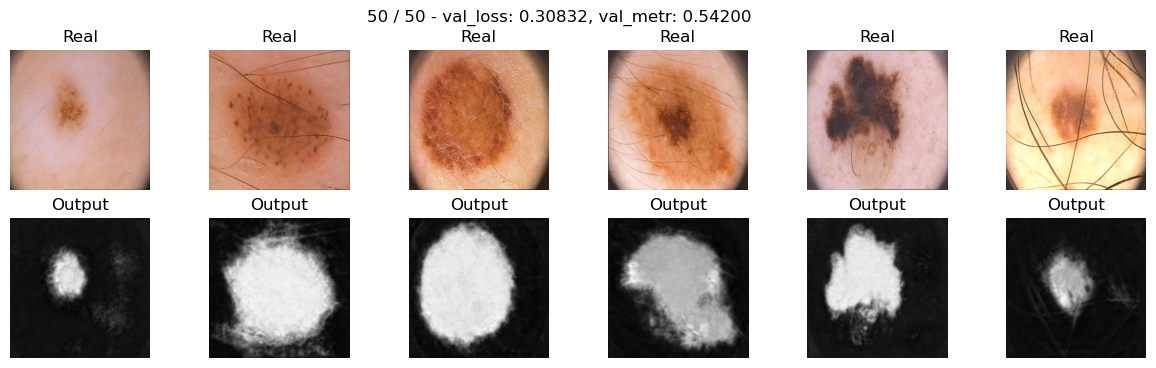

In [31]:
max_epochs = 50
optim=torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
res_bct, acc_bce = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [32]:
score_model(model, iou_pytorch, data_val)

0.542000025510788

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [38]:


# если 0 <= X, Y < 256, следует разделить на 256
# если 0 <= X, Y < 1, делить не нужно

def dice_loss(y_real, y_pred, from_logits=True):
    if from_logits:
        y_pred = torch.sigmoid(y_pred)
    num = torch.sum(y_real * y_pred)
    den = torch.sum(y_real + y_pred)
    res = 2 * num / (den or 1)             # если den == 0
    return 1 - res # / 256



Проводим тестирование:

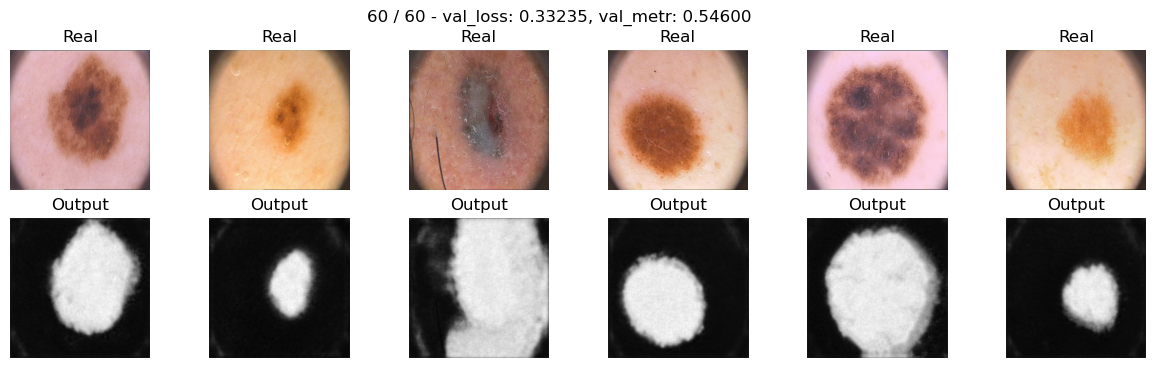

In [41]:
model_dice = SegNet().to(device)
MAX_EPOCHS = 60
optimizer = torch.optim.Adam(model_dice.parameters())
res_dice, acc_dice = train(model_dice, optimizer, dice_loss, MAX_EPOCHS, data_tr, data_val)


In [42]:
score_model(model_dice, iou_pytorch, data_val)


0.5459999740123749

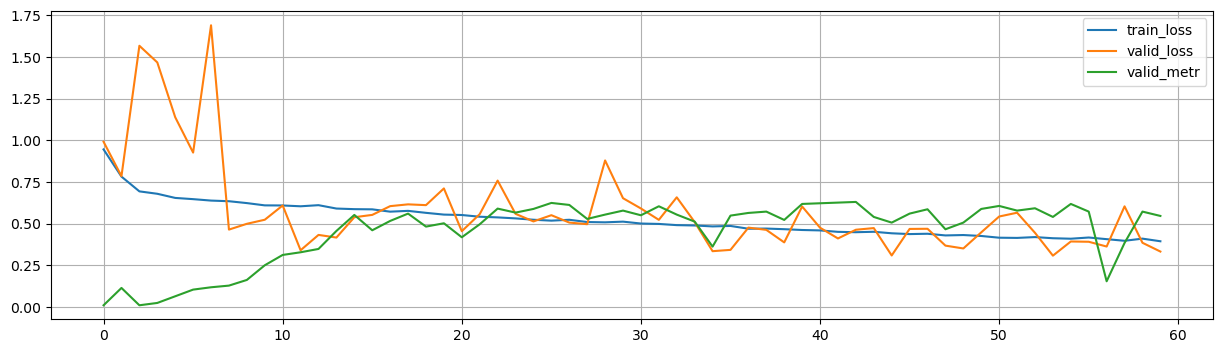

In [43]:
res, acc = res_dice, acc_dice
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [33]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    y_pred = torch.sigmoid(y_pred)

    y_pred = torch.clamp(y_pred, eps, 1 - eps)

    loss = -y_real * (1 - y_pred).pow(gamma) * torch.log(y_pred) - (1 - y_real) * y_pred.pow(gamma) * torch.log(1 - y_pred)

    return loss.mean()


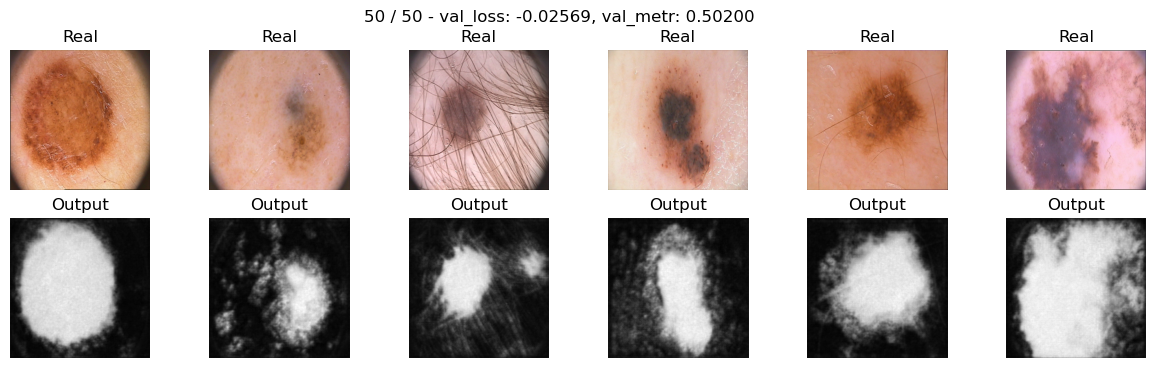

In [52]:
max_epochs = 50              
model_focal = SegNet().to(device)
optimaizer = torch.optim.Adam(model_focal.parameters())
res_focal, acc_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)



In [53]:
score_model(model_focal, iou_pytorch, data_val)


0.502000018954277

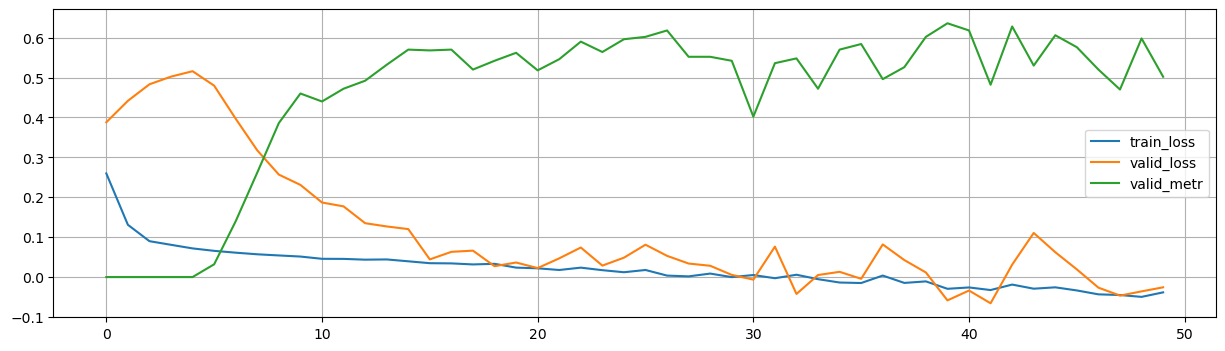

In [54]:
res, acc = res_focal, acc_focal
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

Буду пробовать использовать функцию потерь Хьюбера, которая представляет собой комбинацию среднеквадратичной ошибки (Mean Squared Error, MSE) и среднеабсолютной ошибки (Mean Absolute Error, MAE).

$HuberLoss(y, \hat{y}) = 
\begin{cases}
\frac{1}{2}(y - \hat{y})^2 & \text{если } |y - \hat{y}| \leq \delta \\
\delta(|y - \hat{y}| - \frac{1}{2}\delta) & \text{во всех других случаях}
\end{cases}$

где $\delta$ - пороговое значение, которое определяет, когда следует использовать квадратичную, а когда абсолютную ошибку.

In [26]:
def huber_loss(y_real, y_pred, delta=1.0):
    residual = torch.abs(y_real - y_pred)
    loss = torch.where(residual < delta, 0.5 * residual ** 2, delta * (residual - 0.5 * delta))
    return loss.mean()

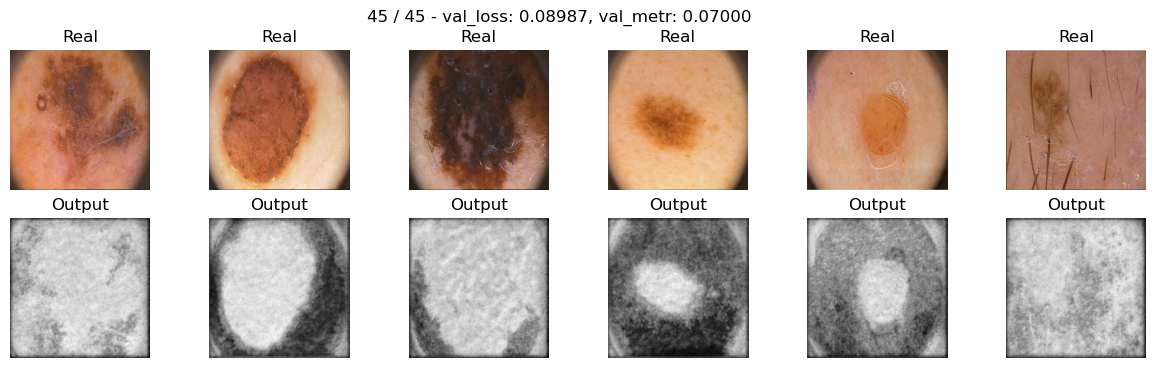

In [27]:
max_epochs = 35              
model_huber = SegNet().to(device)
optim = torch.optim.Adam(model_huber.parameters())
res_huber, acc_huber = train(model_huber, optim, huber_loss, max_epochs, data_tr, data_val)


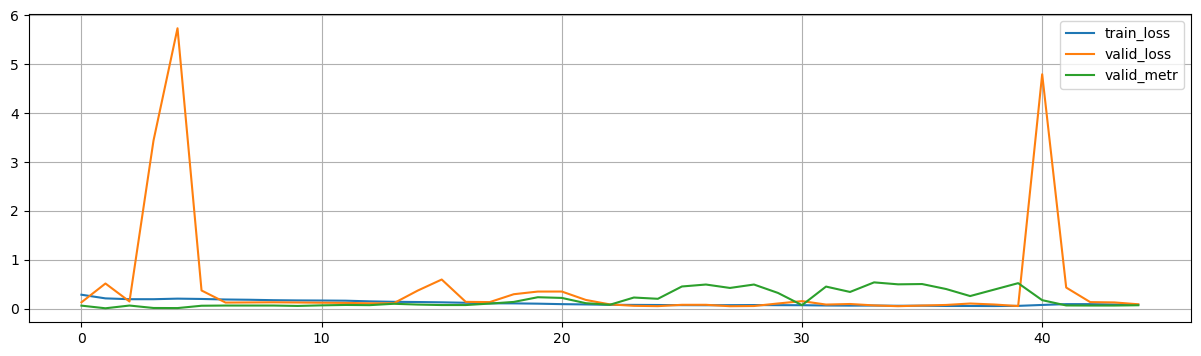

In [28]:
res, acc = res_huber, acc_huber
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

Здесь видно на графике, что модель в самом конце столкнулась с переобучением, а на 25-40 эпохе все было в порядке и был достаточно большой скор

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

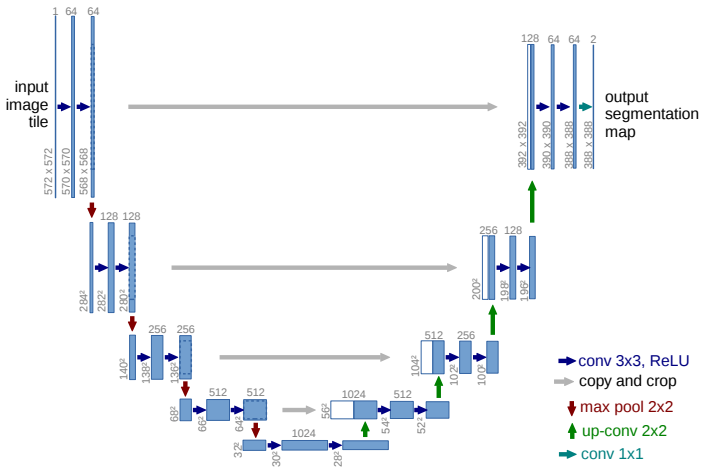

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [29]:
class OneUnit(nn.Module):
    """
    Блок Conv2D + BatchNorm + Relu
    param ker_size: размер стороны квадратного ядра свёртки, int
    param stride_size: отступ страйда, int
    param pad_size: отступ паддинга, int
    """
    def __init__(self, in_channels, out_channels, ker_size, stride_size, pad_size):
        super(OneUnit, self).__init__()
        self.unit = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=ker_size, 
                      padding=pad_size, stride=stride_size),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.unit(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            OneUnit(3,  64, 3, 1, 1),
            OneUnit(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            OneUnit(64,  128, 3, 1, 1),
            OneUnit(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            OneUnit(128, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            OneUnit(256, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottle_neck = nn.Sequential(
            OneUnit(512,  1024, 1, 1, 0),
            OneUnit(1024, 1024, 1, 1, 0),
            OneUnit(1024,  512, 1, 1, 0),
        )

        # decoder (upsampling)

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            OneUnit(512 * 2, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            OneUnit(256 * 2, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            OneUnit(128 * 2, 128, 3, 1, 1),
            OneUnit(128,  64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            OneUnit(64 * 2, 64, 3, 1, 1),

            # последний блок отличается от паттерна
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # в последнем слое активация не нужна
        )

    def forward(self, inp):
        # encoder
        enc00 = self.enc_conv0(inp)
        enc0, idx0 = self.pool0(enc00)
        enc10 = self.enc_conv1(enc0)
        enc1, idx1 = self.pool1(enc10)
        enc20 = self.enc_conv2(enc1)
        enc2, idx2 = self.pool2(enc20)
        enc30 = self.enc_conv3(enc2)
        enc3, idx3 = self.pool3(enc30)        

        # bottleneck        
        neck = self.bottle_neck(enc3)

        # decoder
        dec3 = self.dec_conv3(torch.cat([self.upsample3(neck, idx3), enc30], 1))
        dec2 = self.dec_conv2(torch.cat([self.upsample2(dec3, idx2), enc20], 1))
        dec1 = self.dec_conv1(torch.cat([self.upsample1(dec2, idx1), enc10], 1))
        dec0 = self.dec_conv0(torch.cat([self.upsample0(dec1, idx0), enc00], 1))

        # no activation

        return dec0

In [36]:
unet_model = UNet().to(device)

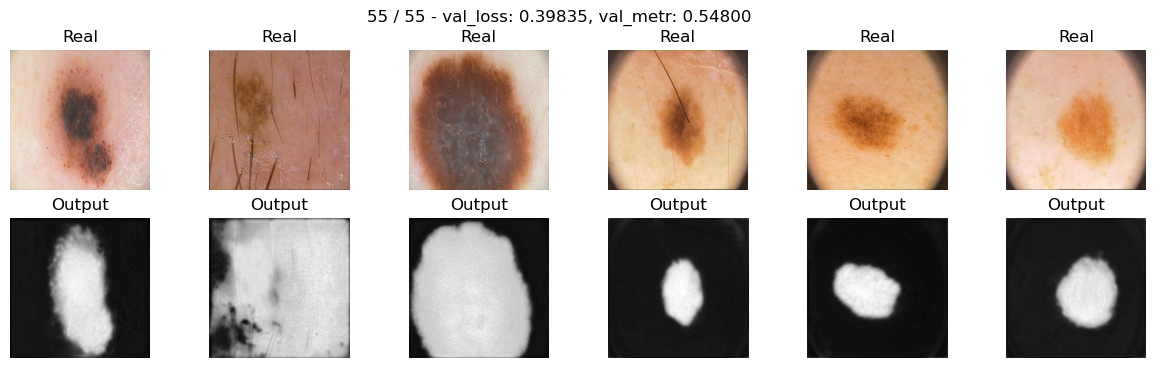

In [37]:
res_unet=train(unet_model, torch.optim.Adam(unet_model.parameters()), bce_loss, 55, data_tr, data_val) 

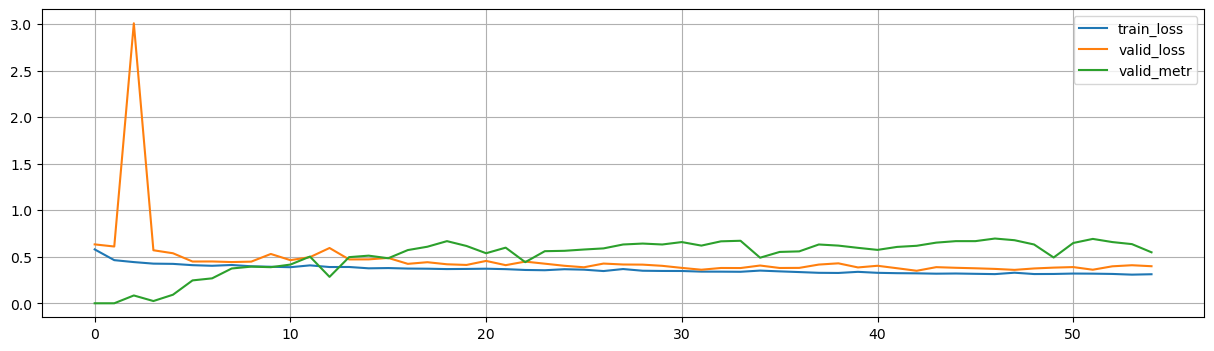

In [38]:
res, acc = res_unet
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

In [39]:
score_model(unet_model, iou_pytorch, data_val)

0.5480000078678131

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [34]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            OneUnit(3,  64, 3, 1, 1),
            OneUnit(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            OneUnit(64,  128, 3, 1, 1),
            OneUnit(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            OneUnit(128, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            OneUnit(256, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottle_neck = nn.Sequential(
            OneUnit(512,  1024, 1, 1, 0),
            OneUnit(1024, 1024, 1, 1, 0),
            OneUnit(1024,  512, 1, 1, 0),
        )

        # decoder (upsampling)

        self.upsample3 = nn.ConvTranspose2d(512, 512, 
                            kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            OneUnit(512 * 2, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 256, 3, 1, 1),
        )

        self.upsample2 = nn.ConvTranspose2d(256, 256, 
                            kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            OneUnit(256 * 2, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 128, 3, 1, 1),
        )

        self.upsample1 = nn.ConvTranspose2d(128, 128, 
                            kernel_size=3, stride=2, padding=1) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            OneUnit(128 * 2, 128, 3, 1, 1),
            OneUnit(128,  64, 3, 1, 1),
        )

        self.upsample0 = nn.ConvTranspose2d(64, 64, 
                            kernel_size=3, stride=2, padding=1) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            OneUnit(64 * 2, 64, 3, 1, 1),

            # последний блок отличается от паттерна
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # в последнем слое активация не нужна
        )

    def forward(self, inp):
        # encoder
        enc00 = self.enc_conv0(inp)
        enc0  = self.pool0(enc00)
        enc10 = self.enc_conv1(enc0)
        enc1  = self.pool1(enc10)
        enc20 = self.enc_conv2(enc1)
        enc2  = self.pool2(enc20)
        enc30 = self.enc_conv3(enc2)
        enc3  = self.pool3(enc30)        

        # bottleneck        
        neck = self.bottle_neck(enc3)

        # decoder
        dec3 = self.dec_conv3(torch.cat([self.upsample3(neck, 
                                        output_size=enc30.size()), enc30], 1))
        dec2 = self.dec_conv2(torch.cat([self.upsample2(dec3, 
                                        output_size=enc20.size()), enc20], 1))
        dec1 = self.dec_conv1(torch.cat([self.upsample1(dec2, 
                                        output_size=enc10.size()), enc10], 1))
        dec0 = self.dec_conv0(torch.cat([self.upsample0(dec1, 
                                        output_size=enc00.size()), enc00], 1))

        # no activation

        return dec0

In [40]:
unet2_model = UNet2().to(device)


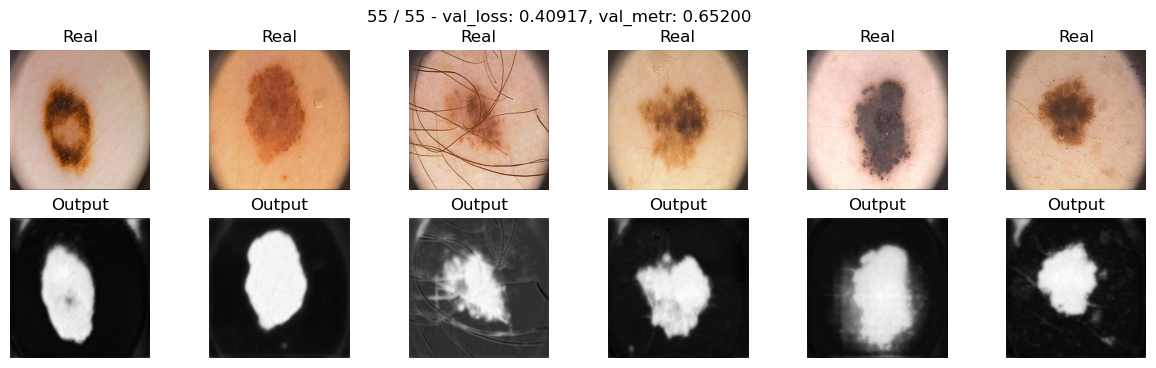

In [42]:
res_unet2=train(unet2_model, torch.optim.Adam(unet2_model.parameters()), bce_loss, 55, data_tr, data_val)


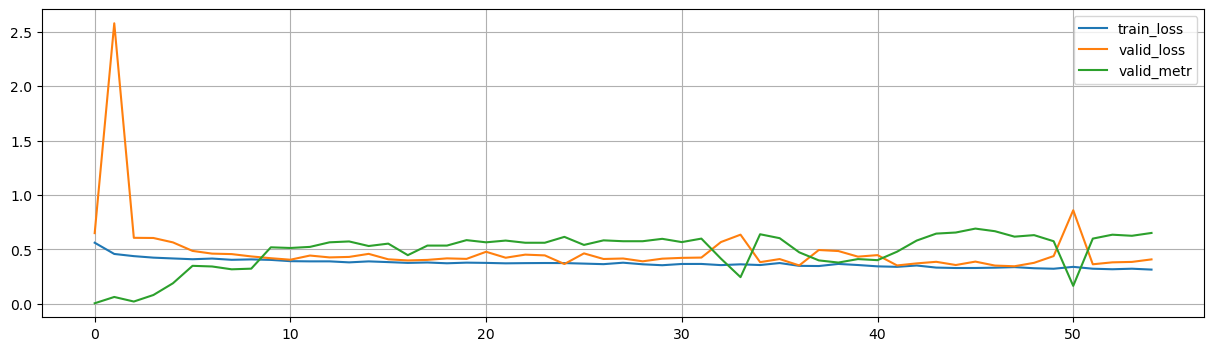

In [43]:
res, acc = res_unet2
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

In [44]:
score_model(unet2_model, iou_pytorch, data_val)

0.6520000100135803

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# Отчет
Было проведено сравнение различных функций потерь для различных нейросетевых архитектур для решения задачи семантической сегментации путем обучения моделей этих архитектур с различными функциями потерь, а также при помощи построения графика обучения. Ниже приведены эти графики, а также ошибка на валидационной выборке и IoU метрика.

## SegNet

Бинарная кросс-энтропия для SegNet:
val_loss: 0.30832, score: 0.54200
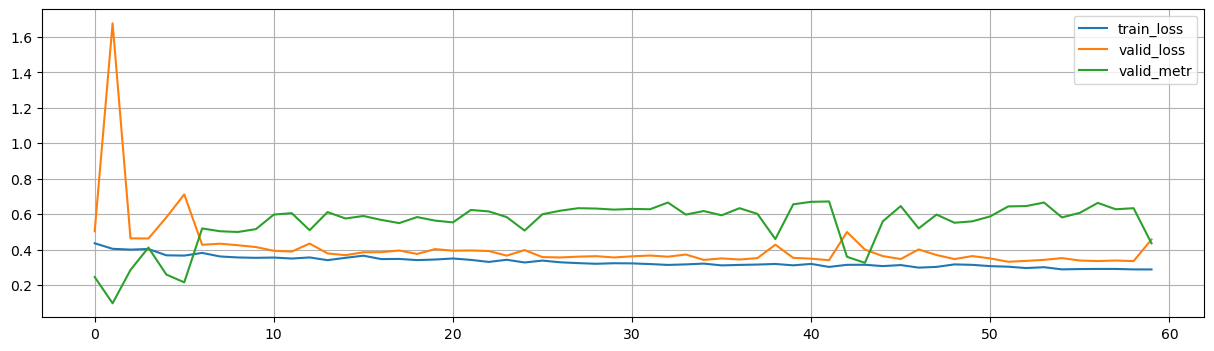

Dice loss для SegNet:
val_loss: 0.33235, score: 0.546
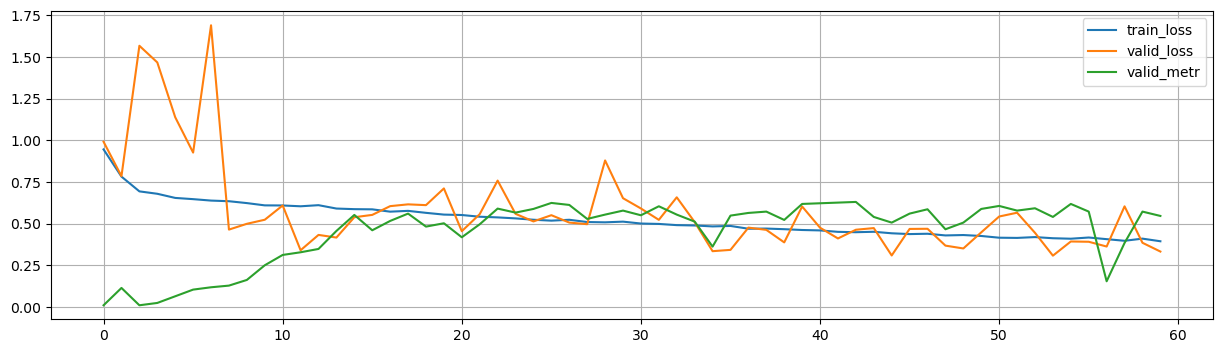

Focal loss для SegNet:
val_loss: -0.02569, score: 0.502
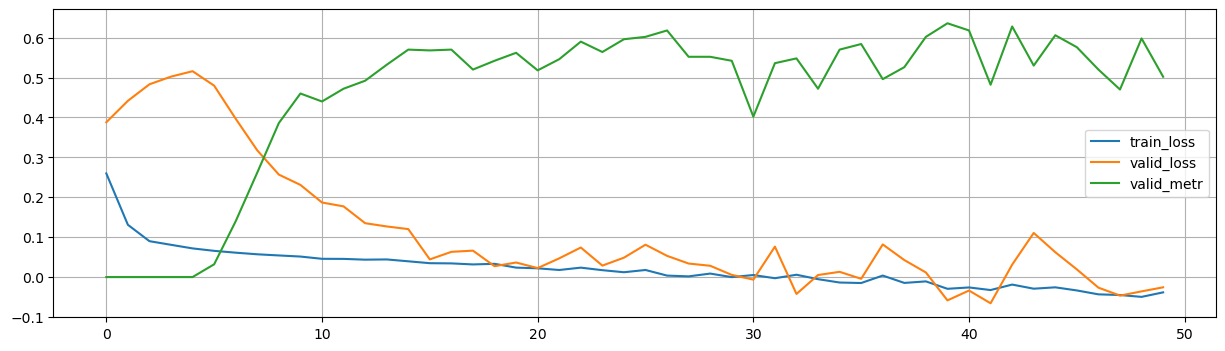

Huber loss для SegNet:
val_loss: 0.08987, score: 0.07 (на графике видно, что модель столкнулась с переобучением, а до этого все было в порядке)
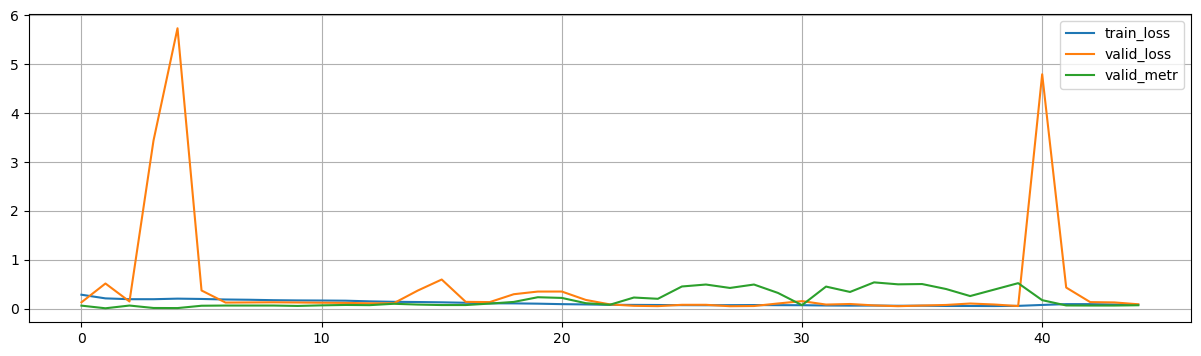

Лучше всего для SegNet оказалась функция потерь Dice loss. Я предполагаю, что это во многом из-за того, что она имеет меньший риск переобучения

Очень интересно повела себя функция потерь Хьюбера, так как она вышла на приемлемый уровень скора только после 25й эпохи, а Focal loss оказался к моему удивлению худшей функцией ошибки

# U-Net и U-Net 2

Бинарная кросс-энтропия для U-Net:
val_loss: 0.39835, score: 0.548
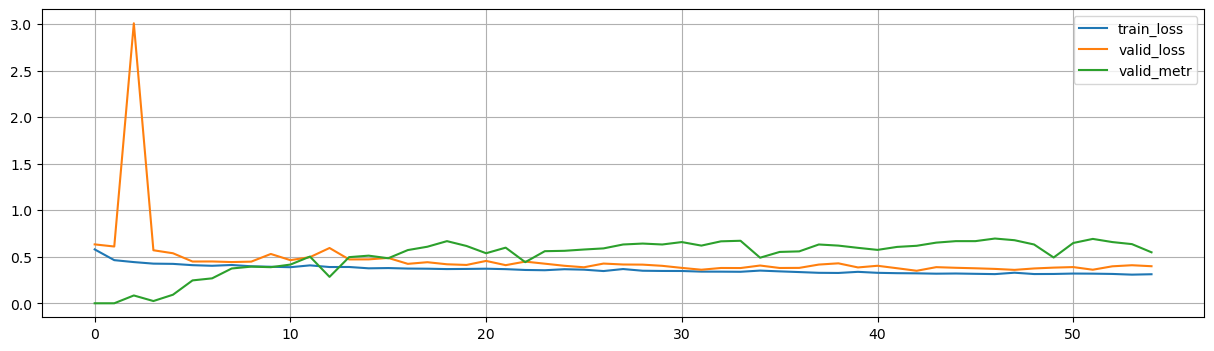

Бинарная кросс-энтропия для U-Net 2:
val_loss: 0.40917, score: 0.652
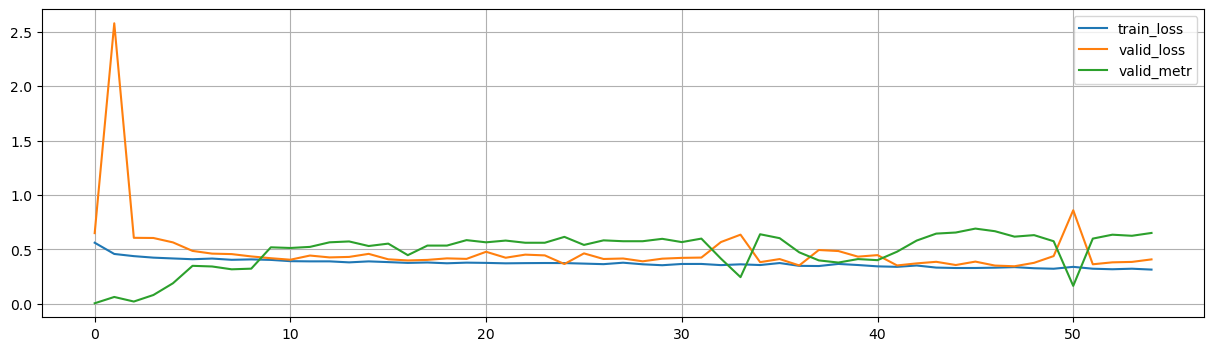

U-Net 2 c функцией бинарной кросс-энтропии оказался лучшим как среди своего класса, так и среди всех обученных моделей в целом, но при этом он и обучался дольше всех. Она обучалась примерно 1.5 часа, в то время как все модели SegNet обучались не дольше 10 минут. По паттернам сегментации наиболее приятный на мой взгляд SegNet c focal loss. Как в SegNet, так и в U-Net и U-Net 2 слишком много параметров для такого маленького датасета. Если бы датасет был больше, можно было бы обучать больше эпох и не бояться переобучения во всех случаях.

В общем и целом наиболее оптимальной моделью по соотношению времени обучения к качеству является SegNet c Dice loss, так что я бы использовал ее в следующих работах :)